## Importiere `pandas`, `matplotlib`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import json
from datetime import datetime as dt
import locale
from scipy.interpolate import interp1d
from configparser import ConfigParser
from functions import *

## Lade die Konfigurationen aus `config.ini`
#### Definiere die Umgebung

In [2]:
config = ConfigParser()
files = config.read('config.ini')

# Wechsel des plt.style per config.ini machbar.
plt.style.use(config.get('theme', 'plt.style'))

# Damit Daten mit den deutschen Begriffen für die Monat generiert werden.
locale = locale.setlocale(locale.LC_TIME, "de_DE")

In [3]:
env = 'test'
database_file = config.get(env, 'database_file')
date_begin = config.get(env, 'date_begin')
date_end = config.get(env, 'date_end')
dpi = config.get(env, 'dpi')

# Beginn

In [4]:
df = pd.read_json(database_file)

#### Filter die Artikel nach: Sind zwischen dem und dem Datum veröffentlich worden.

In [5]:
df = df.loc[(df['date'] >= date_begin) & (df['date'] <= date_end)]

#### Füge zwei neue Features hinzu: Anzahl Wörter, Anzahl Zeichen

In [6]:
df['content_length'] = df['content'].str.len()
df['content_words'] = df['content'].str.split().map(len)

#### Füge ein neues Feature hinzu: Themengebiet

In [7]:
topics = json.loads(open("topics/topics.json", "r").read())

df['tags_full'] = ['; '.join(tags) for tags in df['tags'].to_list()]

for topic in topics:
    df.loc[(df.title.str.contains('|'.join(topics[topic]['keywords'])) | df.tags_full.str.contains('|'.join(topics[topic]['keywords']))), 'topic'] = topic

## Gruppiere die Artikel nach: Themengebiet
#### Aggregiere pro Themengebiet die Durchschnittsanzahl Wörter/Zeichen

In [8]:
df = df.groupby(['topic']).agg({"content_length": "mean", "content_words": "mean"})

#### Sortiere die Artikel nach: Anzahl Zeichen (absteigend)

In [9]:
df = df.sort_values("content_length", ascending=False)

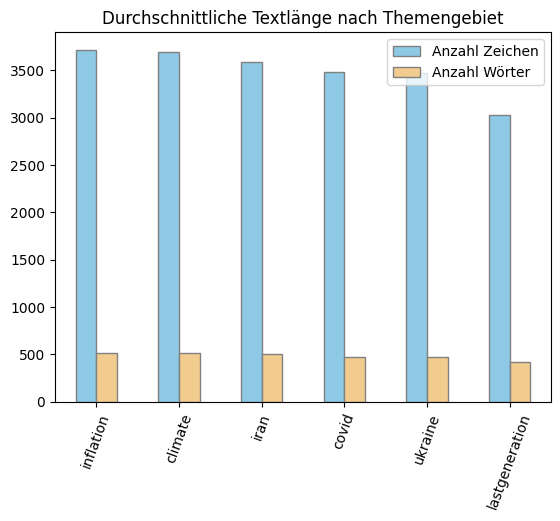

In [10]:
ax = df.plot(kind="bar", y=['content_length', 'content_words'], color=["#8ecae6", "#f2cc8f"], edgecolor=["grey"], rot=70)

ax.set_title('Durchschnittliche Textlänge nach Themengebiet')
ax.legend(["Anzahl Zeichen", "Anzahl Wörter"])
ax.xaxis.label.set_visible(False)

ax.get_figure().savefig('figures/bar-length-topic.png', bbox_inches="tight", dpi=dpi)